# Advanced Lane Finding
This code overlays the drivable area between two lanes on an image or video of a car driving on a road, as shown below.

It goes through the following steps:
- Step 0: Import Libraries
- Step 1: Calibrate Camera
- Step 2: Undistort Image
- Step 3: Apply Colour and Gradient Thresholding
- Step 4: Perspective Transform
- Step 5: Find Lane Lines
- Step 6: Measure Curvative
- Step 7: Draw Lane Area on Image
- Step 8: Sanity Check
- Step 9: Look-Ahead Filter
- Step 10: Image Pipeline
- Step 11: Video Pipeline

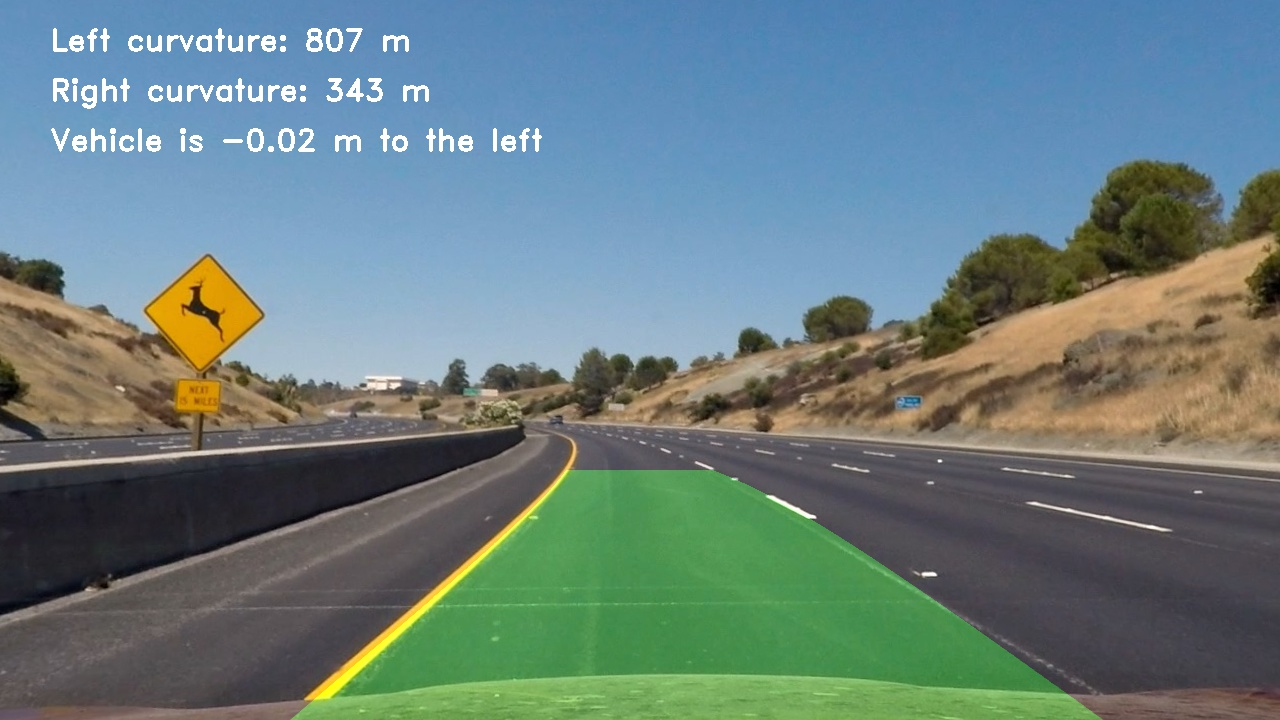

## Step 0: Import Libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

## Step 1: Calibrate Camera
Feed into this function a number of chessboard images (20 for accuracy) taken by a camera, and it returns a camera matrix (mtx) and distortion coefficients (dist), which can be used to undistort other images taken by this camera.

**How**: The corners on a chessboard image taken by a camera can be detected by the *cv2.findChessboardCorners()* function, and this is compared with the corners of a perfect 2D chessboard image. The camera matrix (mtx) and distortion coefficients (dist) can be computed from this comparison using the *cv2.calibrateCamera()* function.

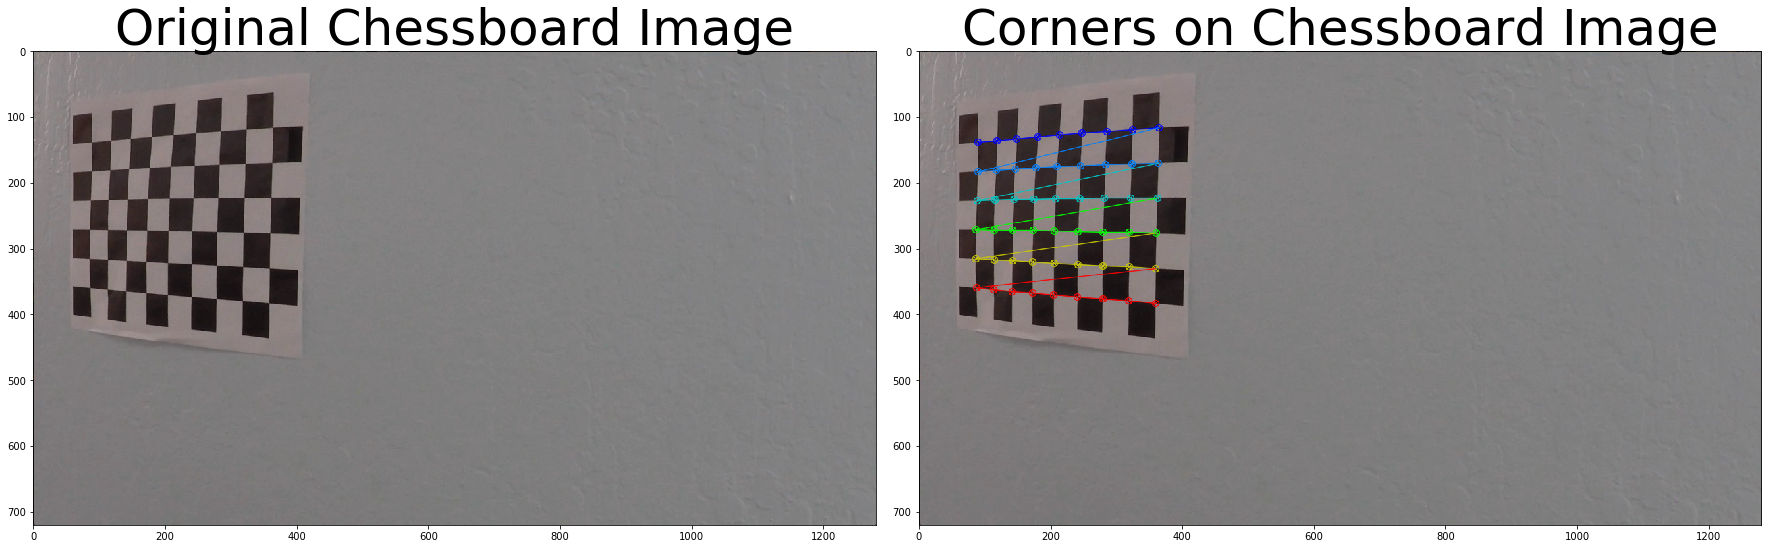

In [3]:
def calibrate_camera(images, nx, ny):    
    # Prepare object points like (0,0,0), (1,0,0),...,(8,5,0)
    objp = np.zeros((ny*nx,3),np.float32) 
    
    # (x,y) coordinates
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 
    
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Chessboard Image', fontsize=50)
    ax2.imshow(cv2.drawChessboardCorners(img, (nx, ny), corners, ret))
    ax2.set_title('Corners on Chessboard Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #cv2.imwrite("output_images/corners_on_chessboard_image.jpg",cv2.cvtColor(cv2.drawChessboardCorners(img, (nx, ny), corners, ret), cv2.COLOR_RGB2BGR))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    
    return mtx, dist

chessboard_images = glob.glob("camera_cal/calibration*.jpg")
nx = 9
ny = 6
mtx, dist = calibrate_camera(chessboard_images, nx, ny)


## Step 2: Undistort Image
Takes in a camera image, camera matrix and distortion coefficients (from Step 1), and returns an undistorted image using the *cv2.undistort()* function.

**Why**: Camera lenses cause images taken to be slightly distorted, affecting the shape and size of the objects in the images. This is a problem for lane detection, as the distortion causes the lane curvature measured from the image and eventually steering angle to be wrong.

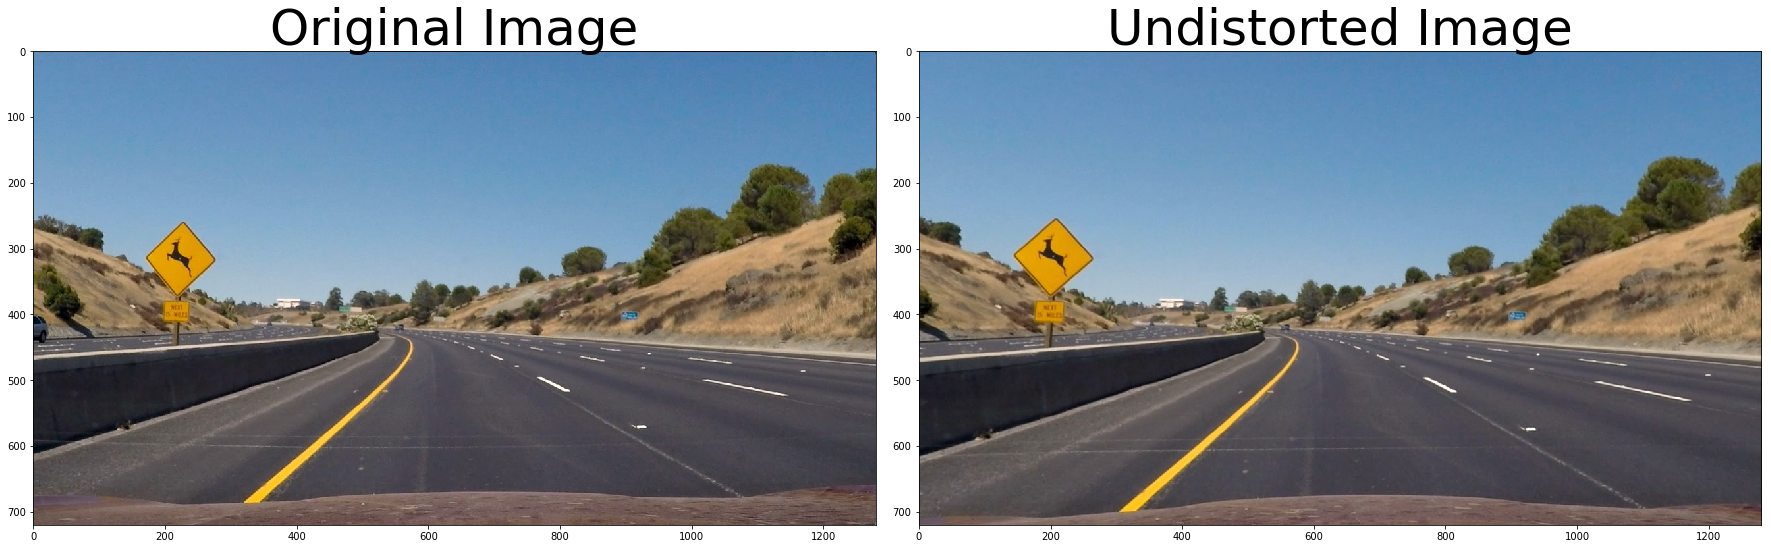

In [4]:
img = cv2.imread("test_images/test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

undistorted_img = undistort_image(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#cv2.imwrite("output_images/undistorted_image.jpg",cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR))

## Step 3: Apply Colour and Gradient Thresholding
Takes in an undistorted image and returns a binary image with a combination of colour and gradient thresholding applied.

A. Gradient Thresholding:
- Sobel x using the *abs_sobel_thresh(orient='x')* function, which emphasizes vertical edges
- Sobel y using the *abs_sobel_thresh(orient='y')* function, which emphasizes horizontal edges
- Magnitude of gradient using the *mag_thresh()* function, which is the magnitude of Sobel x and Sobel y. This is equivalent to using the Canny edge detection filter, and is good for picking up all edges.
- Direction of gradient using the *dir_thresh()* function, which picks out edges of a particular orientation (in this case, orientation of lane lines)

B. Colour Thresholding:
- In the HLS space (hue, lightness, and saturation), the Saturation (S) channel picks up the lane lines well under very different color and contrast conditions, hence the S colour threshold is chosen

C. Combining Thresholds:
- In the *combined_col_grad_thresh()* function, the different thresholds described in (A) and (B) are combined in the following way:
- {[(Sobel x **and** Sobel y) **or** (mag_thresh **and** dir_thresh)] **or** s_channel}

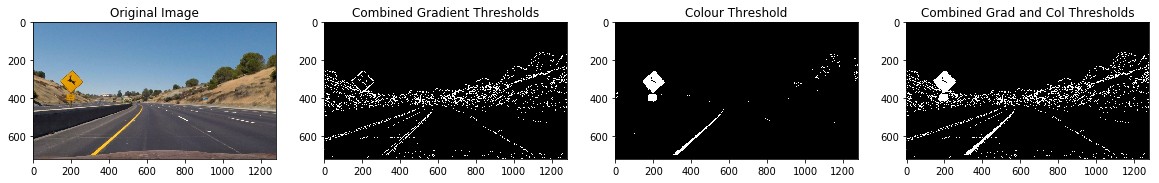

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled_sobel = None
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    abs_magnitude = np.absolute(magnitude)
    
    scaled_magnitude = np.uint8(255*abs_magnitude/np.max(abs_magnitude))
    
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    
    #cv2.imwrite("output_images/mag_binary.jpg",mag_binary*255)
    
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    #cv2.imwrite("output_images/dir_binary.jpg",dir_binary*255)
    
    return dir_binary


def combined_col_grad_thresh(img, plot=False):

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    
    #cv2.imwrite("output_images/gradx_binary.jpg",gradx*255)
    #cv2.imwrite("output_images/grady_binary.jpg",grady*255)
    
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.7, 1.4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    #cv2.imwrite("output_images/s_binary.jpg",s_binary*255)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    
    if plot == True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax2.set_title('Combined Gradient Thresholds')
        ax2.imshow(combined, cmap='gray')
        ax3.set_title('Colour Threshold')
        ax3.imshow(s_binary, cmap='gray')
        ax4.set_title('Combined Grad and Col Thresholds')
        ax4.imshow(combined_binary, cmap='gray')
        
    return combined_binary

combined_binary = combined_col_grad_thresh(undistorted_img, True)

#cv2.imwrite("output_images/combined_binary.jpg",combined_binary*255)

## Step 4: Perspective Transform
Takes in an undistorted, thresholded binary image, and returns a warped top-down view of the image and perspective transform matrix (M) which will be used in Step 7.

**How**: 4 source (src) points from the binary image are chosen, resembling a trapezium around the lane lines boundary. 4 destination (dst) points on the resulting top-down image are chosen, to map the trapezium shape into a rectangle shape using the *cv2.getPerspectiveTransform()* function.

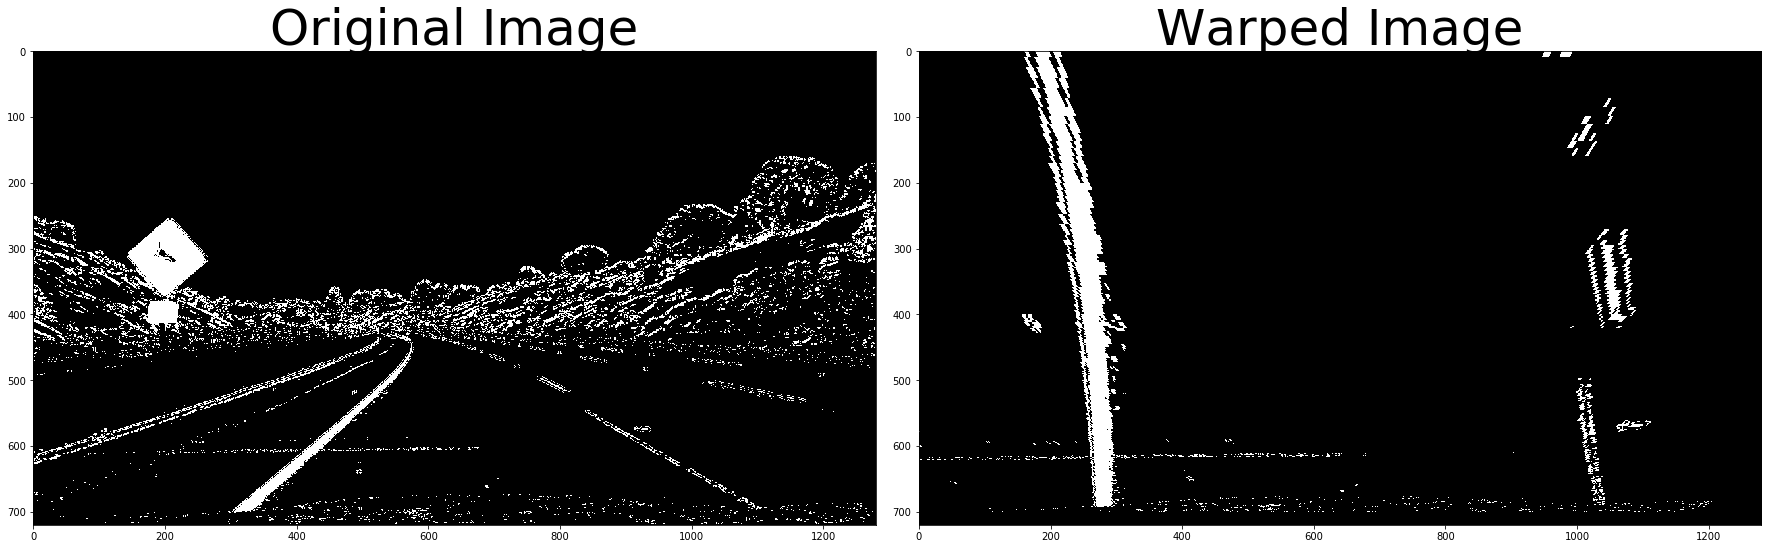

In [7]:
def perspective_transform(img): 
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[568,470], [260,680], [717,470], [1043,680]])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    
    return warped, M

warped_img, M = perspective_transform(combined_binary) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img,cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#cv2.imwrite("output_images/warped_img.jpg",warped_img*255)


## Step 5: Find Lane Lines
Here, two functions are defined.

1) The *sliding_windows()* function takes in a binary top-down image, and returns the coefficients of the polynomials for the left and right lanes. This is the full algorithm used to find the lane lines from scratch, using histogram to perform a blind search.

2) The *search_from_prior()* function takes in a binary top-down image, previous coefficients of the polynomials for the left and right lanes, and returns updated coefficients. This is a shorter algorithm that does a targeted search in the margin around the previous line position.

The Look-Ahead Filter in Step 9 will decide which of these functions should be used.

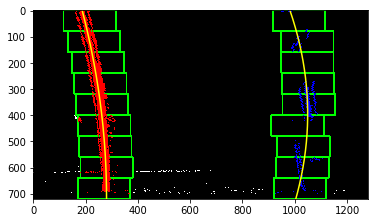

In [8]:
def sliding_windows(binary_warped, plot=False):
        
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack([binary_warped]*3)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,1,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,1,0), 5)
        
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
 
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    if plot == True:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[lefty, leftx] = [1, 0, 0]
        out_img[righty, rightx] = [0, 0, 1]

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return left_fit, right_fit, out_img
    else:
        return left_fit, right_fit
    
left_fit, right_fit, sliding_windows_img = sliding_windows(warped_img, True)
plt.imshow(sliding_windows_img)
#cv2.imwrite("output_images/sliding_windows_img.jpg",sliding_windows_img*255)

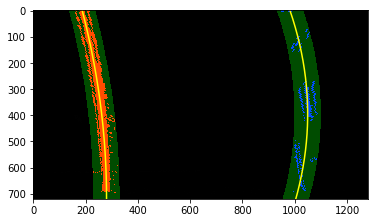

In [9]:
def search_from_prior(left_fit, right_fit, binary_warped, plot=False):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    if plot == True:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        return left_fit_new, right_fit_new, result
    else:
        return left_fit_new, right_fit_new
    
left_fit, right_fit, search_from_prior_img = search_from_prior(left_fit, right_fit, warped_img, True)
plt.imshow(search_from_prior_img)
#cv2.imwrite("output_images/search_from_prior_img.jpg",search_from_prior_img*255)

## Step 6: Measure Curvature
Takes in a binary top-down image, and the coefficients of the polynomials for the left and right lanes. Returns the radius of curvature for the left and right lanes, and the vehicle offset from the lane centre, in metres.

In [10]:
def measure_curvature(binary_warped, left_fit, right_fit):
    
    # left_fitx = vector of x values on the lane line for evenly spaced y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space and get their coefficients
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate radius of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Positions of left and right lane bottoms in x dimension, in pixels
    left_lane_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    # Find centre of vehicle with respect to lanes                        
    vehicle_centre = (left_lane_bottom + right_lane_bottom)*0.5

    camera_centre = binary_warped.shape[1]*0.5
    vehicle_offset = (vehicle_centre - camera_centre)*xm_per_pix #Convert to meters
    return left_curverad, right_curverad, vehicle_offset


left_curverad, right_curverad, vehicle_offset = measure_curvature(warped_img, left_fit, right_fit)

## Step 7: Draw Lane Area on Image
Takes in the following:
- Undistorted image, to draw on
- Binary top-down image and coefficients of polynomials of left and right lane lines
- Perspective transform matrix (M), to transform the top-down image back to original image perspective
- Left and right lane radii and vehicle offset dimensions

Returns an image with the area between both lane lines highlighted, and left/right lane radii and vehicle offset displayed.

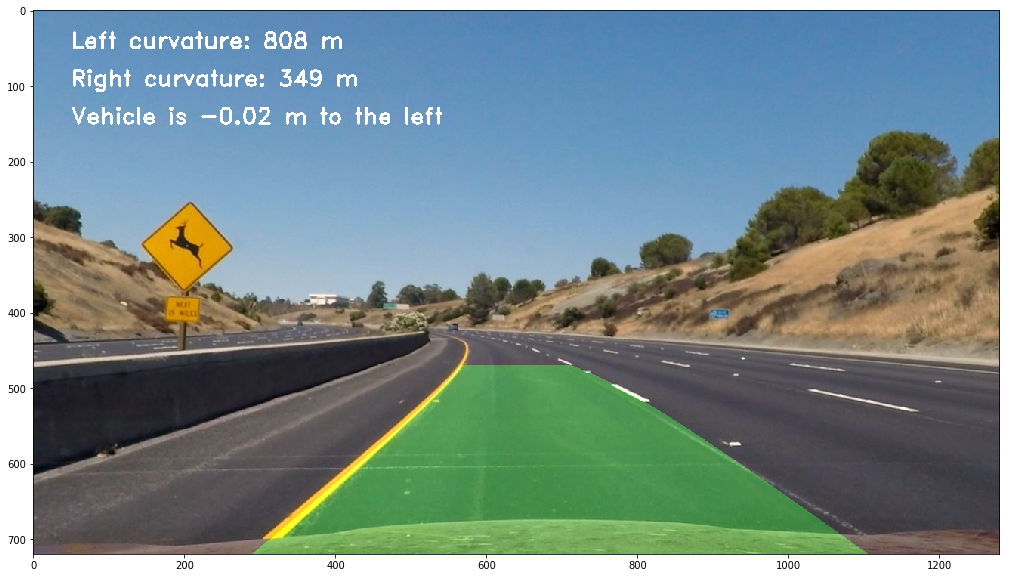

In [14]:
def draw_on_image(undist, warped_img, left_fit, right_fit, M, left_curverad, right_curverad, vehicle_offset, plot=False):
    
    # left_fitx = vector of x values on the lane line for evenly spaced y values
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Determine if vehicle is closer to left or right lane using vehicle_offset parameter
    if vehicle_offset < 0:
        position = 'left'
    else:
        position = "right"
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle is {:.2f} m to the {side}'.format(vehicle_offset, side=position), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if plot == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
    return result

result = draw_on_image(undistorted_img, warped_img, left_fit, right_fit, M, left_curverad, right_curverad, vehicle_offset, True)
#cv2.imwrite("output_images/result.jpg",cv2.cvtColor(result,cv2.COLOR_RGB2BGR))

## Step 8: Sanity Check
Takes in the coefficients of polynomials describing both lane lines, and checks for the following:
- Checking that they have similar curvature
- Checking that they are separated by approximately the right distance horizontally
- Checking that they are roughly parallel

If either condition is not met, a boolean *False* is returned.

In [15]:
def sanity_check(left_fit, right_fit):
    
    # Do checks at y_eval = 360, midpoint of top-down image
    y_eval = 360
    
    # Check for similar gradient, by differentiating equations to get below
    left_grad = 2*left_fit[0]*y_eval + left_fit[1]
    right_grad = 2*right_fit[0]*y_eval + right_fit[1]
    if np.abs(left_grad - right_grad) <= 0.1:
        sanity = True
    else:
        sanity = False
        
    # Check for approximately right distance horizontally
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    if np.abs(left_x - right_x) >= 200 and np.abs(left_x - right_x) <= 1000:
        sanity = True
    else:
        sanity = False
        
    return sanity
    

## Step 9: Look-Ahead Filter
A function that takes in an image, and chooses either the *sliding_windows()* or *search_from_prior()* functions to find the lane lines. 

A class *Lane()* is instantiated to receive and record the characteristics of each video frame. The previous function *sanity_check()* is applied to check the characteristics for bad or difficult video frames. If it returns "False" for:
- A few frames: retain the previous positions from the frame prior, and step to the next frame to search again
- Several frames in a row: start from scratch using *sliding_windows()*

In [16]:
# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        self.prev_left_fit = None
        self.prev_right_fit = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0
        
lane = Lane()

def find_lanes(img):
    undistorted_img = undistort_image(img, mtx, dist)
    combined_binary = combined_col_grad_thresh(undistorted_img)
    warped_img, M = perspective_transform(combined_binary) 
    
    if lane.counter == 0:
        lane.left_fit, lane.right_fit = sliding_windows(warped_img)
    else:
        lane.left_fit, lane.right_fit  = search_from_prior(lane.left_fit, lane.right_fit, warped_img)
    
    # Sanity check
    sanity = sanity_check(lane.left_fit, lane.right_fit)
    
    if sanity == True:        
        lane.prev_left_fit, lane.prev_right_fit = lane.left_fit, lane.right_fit        
        lane.counter += 1
        lane.reset_counter = 0
    else:   
        # Several problematic frames in a row, need to reset
        if lane.reset_counter > 5:
            lane.left_fit, lane.right_fit = sliding_windows(warped_img)
            lane.reset_counter = 0
        # Continue to retain previous positions from prior frame and try
        else:
            lane.left_fit, lane.right_fit = lane.prev_left_fit, lane.prev_right_fit
            
        lane.reset_counter += 1
    
    return warped_img, lane.left_fit, lane.right_fit, M


## Step 10: Image Pipeline

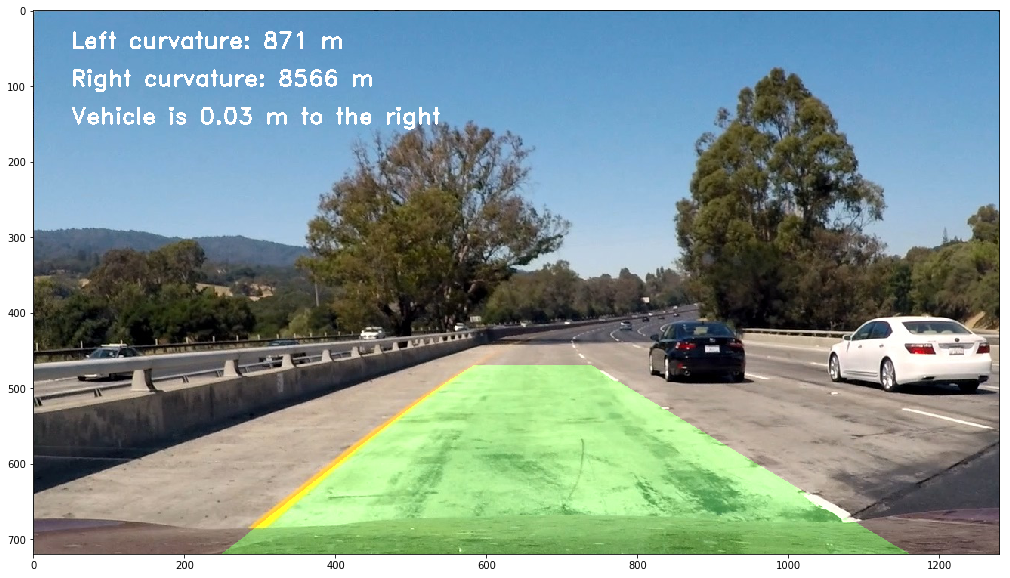

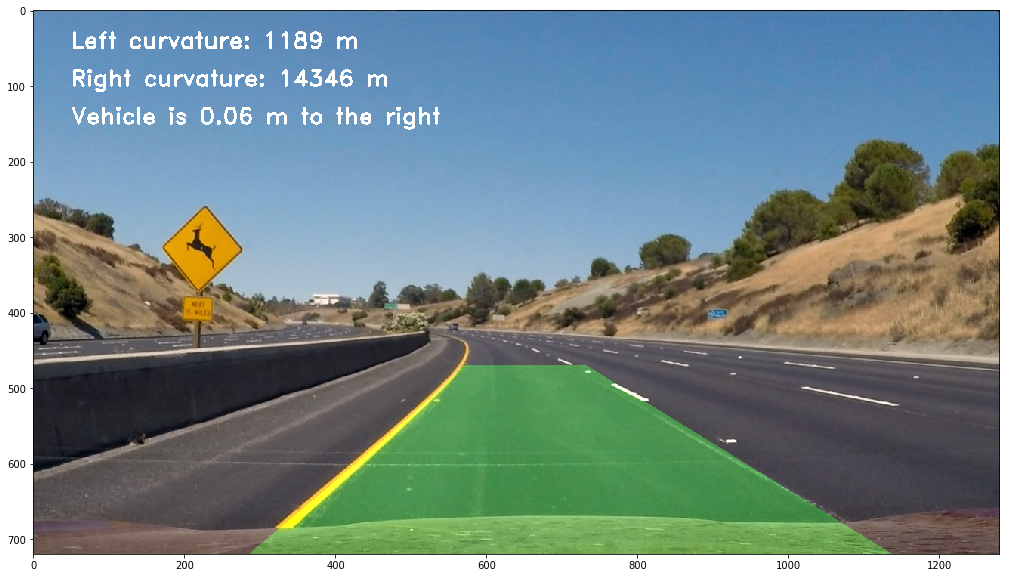

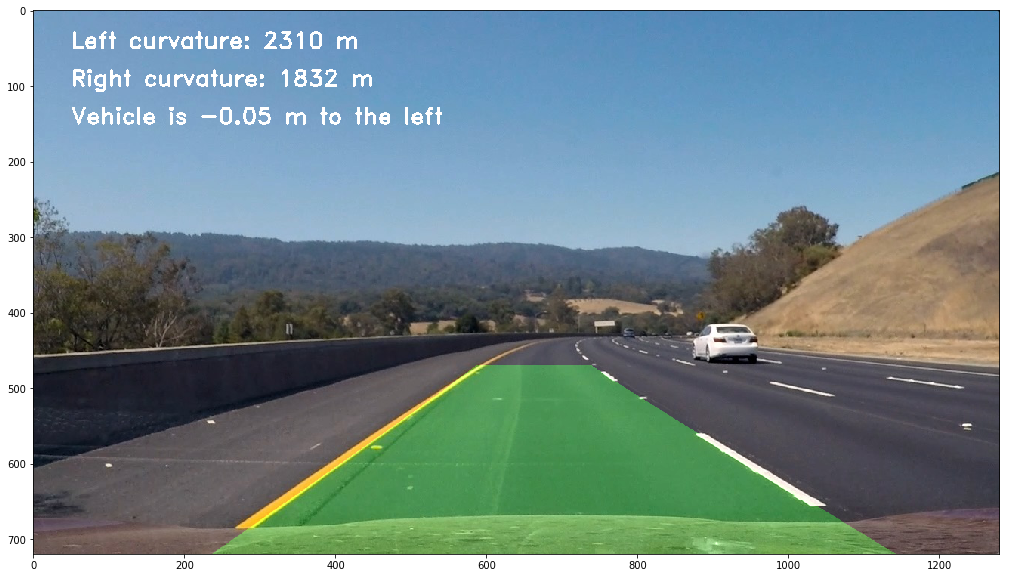

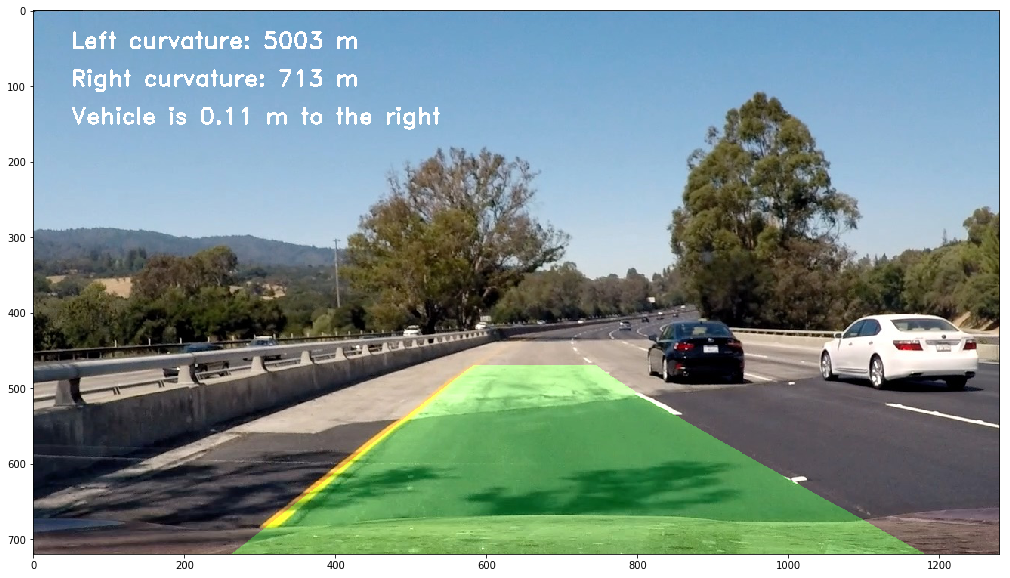

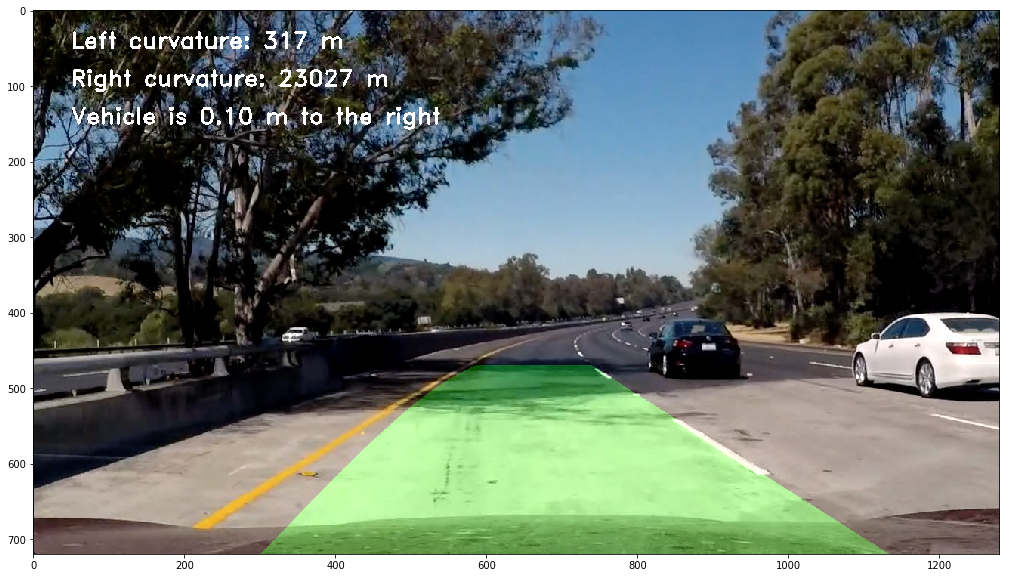

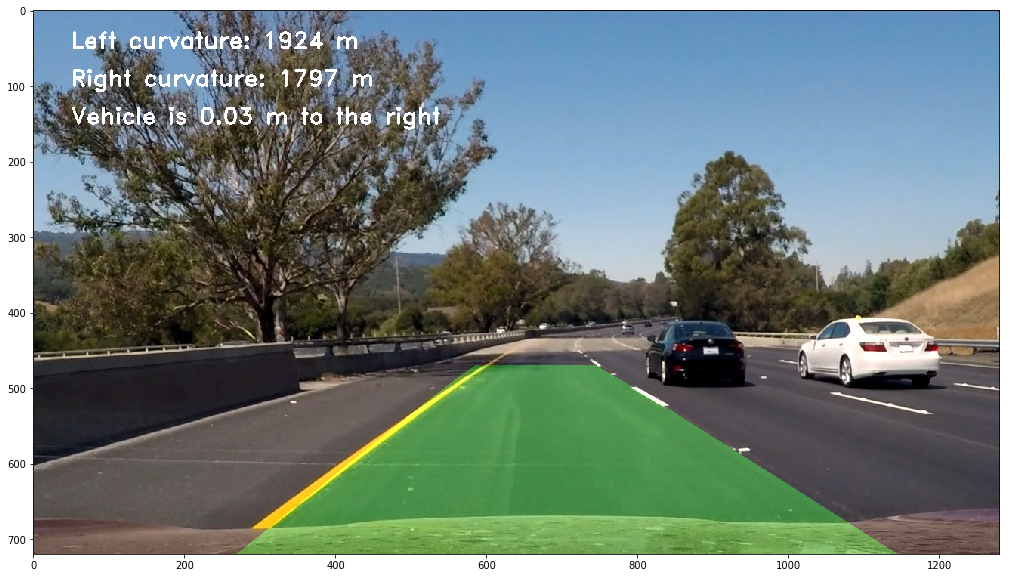

In [19]:
def pipeline(img, plot=False):
    warped_img, left_fit, right_fit, M = find_lanes(img)
    left_curverad, right_curverad, vehicle_offset = measure_curvature(warped_img, left_fit, right_fit)
    
    return draw_on_image(img, warped_img, left_fit, right_fit, M, left_curverad, right_curverad, vehicle_offset, plot)
    
images = ['test1.jpg', 'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']

for fname in images:
    img = cv2.imread('test_images/'+fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pipeline(img, plot=True)

## Step 11: Video Pipeline 

In [70]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane = Lane()
def process_image(img):
    return pipeline(img)

white_output = 'output_video/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [07:52<00:00,  2.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 5min 34s, sys: 2.88 s, total: 5min 37s
Wall time: 7min 55s


In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))